# Can AI Learn Black-Scholes?

## 0. Background

We can develop an argument for Black-Scholes prices assuming a Geometric Brownian Motion, continuous hedging capacity, no arbitrage, etc. However, many models aim to capture more dynamics and stylized facts of the market (e.g. volatility is not constant, prices can jump, there are transaction costs and occasional arbitrage, and much more). 

The tradeoff for a parsimonious and efficient model to develop consistent prices and a more accurate model that capture more dynamics is evident. A stream of academic literature aims to approximate more complicated models using neural networks to aid in pricing accuracy.  

Though there is relative error just like any functional approximate available via neural network, there is evidence in the literature to suggest that these techniques may be productive in pricing large sets of financial instruments where they previously may have been computationally intractable due to scalability and simulation complexity.  

## 1. Black-Scholes Model for European Options

The Black-Scholes pricing formula for a European call option is:

$$ C(S_0, K, T, r, \sigma) = S_0 N(d_1) - K e^{-rT} N(d_2) $$

where:

$$ d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}} $$

$$ d_2 = d_1 - \sigma \sqrt{T} $$

Here:

-$ S_0$ is the initial stock price

-$ K$ is the strike price

-$ T$ is the time to maturity

-$ r$ is the risk-free rate

-$ \sigma$ is the volatility

-$ N(\cdot)$ is the cumulative normal distribution function.

Let's implement this in Python:


In [1]:
import numpy as np
import scipy.stats as si

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    return call_price

# Example usage
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
black_scholes_call(S, K, T, r, sigma)

np.float64(10.450583572185565)

## 2. Simulation of European Option Prices

To verify the Black-Scholes model, we simulate stock price paths using the Geometric Brownian Motion (GBM):

$$ dS_t = r S_t dt + \sigma S_t dW_t $$

where$ W_t$ is a Wiener process. 

Let's simulate and price a European call option:

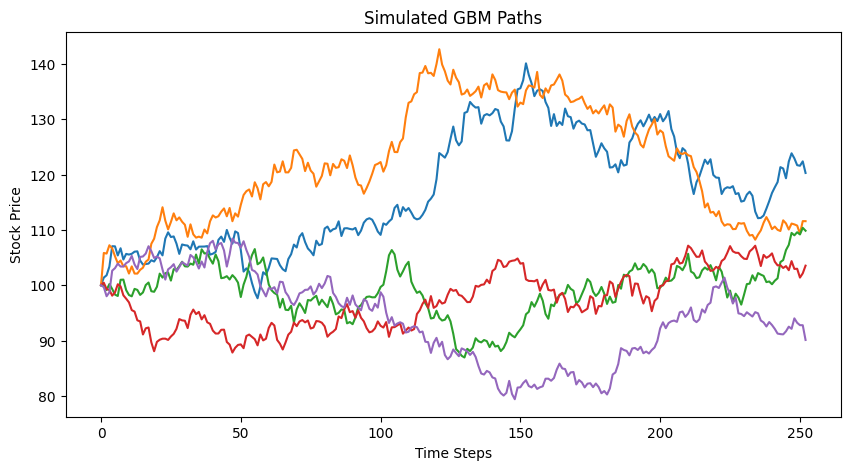

Parameter Set: 100 1 0.05 0.2 252 10000


np.float64(10.653894933185112)

In [6]:
import matplotlib.pyplot as plt

def simulate_gbm(S0, T, r, sigma, steps, n_paths):
    dt = T / steps
    paths = np.zeros((steps + 1, n_paths))
    paths[0] = S0
    
    for t in range(1, steps + 1):
        Z = np.random.standard_normal(n_paths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    
    return paths

# Parameters
S0, T, r, sigma, steps, n_paths = 100, 1, 0.05, 0.2, 252, 10000
gbm_paths = simulate_gbm(S0, T, r, sigma, steps, n_paths)

# Compute European Call option price using Monte Carlo
payoffs = np.maximum(gbm_paths[-1] - K, 0)
mc_price = np.exp(-r * T) * np.mean(payoffs)

# Plot a few simulated paths
plt.figure(figsize=(10, 5))
plt.plot(gbm_paths[:, :5])
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("Simulated GBM Paths")
plt.show()

print('Parameter Set:', S0, T, r, sigma, steps, n_paths)
mc_price

## 3. Basic Feed Forward Neural Network Approximation

We start with a simple example: approximating a quadratic function:

$$ f(x) = x^2 $$

We train a neural network to approximate this function and plot the true function and the network's approximation.


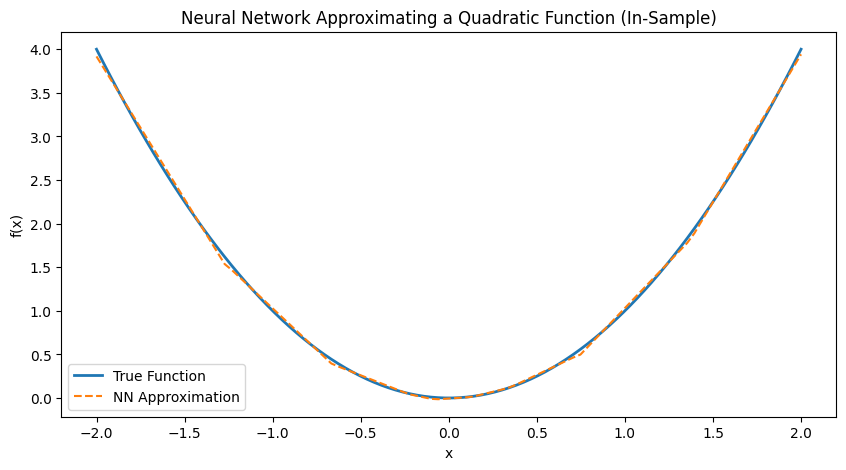

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Generate training data
x_train = np.linspace(-2, 2, 100).reshape(-1, 1)
y_train = x_train**2

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Define neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Plot results
y_pred = model(x_train_tensor).detach().numpy()

plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, label="True Function", linewidth=2)
plt.plot(x_train, y_pred, label="NN Approximation", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Neural Network Approximating a Quadratic Function (In-Sample)")
plt.legend()
plt.show()

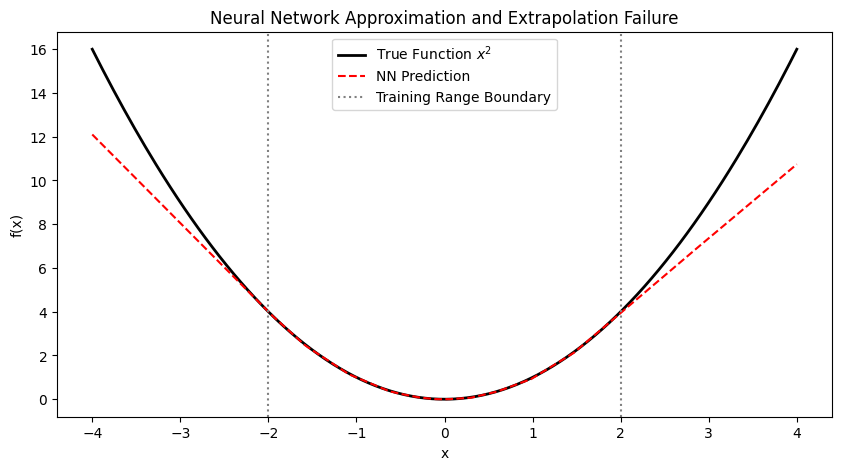

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate training data (x in [-2, 2])
x_train = np.linspace(-2, 2, 100).reshape(-1, 1)
y_train = x_train**2

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Define neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Initialize model, loss function, and optimizer
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Test on both training range and extrapolated range
x_test = np.linspace(-4, 4, 200).reshape(-1, 1)  # Test from -4 to 4
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test = x_test**2  # True function

y_pred = model(x_test_tensor).detach().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(x_test, y_test, label="True Function $x^2$", linewidth=2, color="black")
plt.plot(x_test, y_pred, label="NN Prediction", linestyle="dashed", color="red")
plt.axvline(-2, color="gray", linestyle="dotted", label="Training Range Boundary")
plt.axvline(2, color="gray", linestyle="dotted")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Neural Network Approximation and Extrapolation Failure")
plt.legend()
plt.show()

Analytical Price $\approx$ Numerical Price $\approx$ Neural Network Numerical Price

$C() \approx \tilde{C}() \approx \tilde{\tilde{C()}}$

## **4. Learning Black-Scholes Prices with a Neural Network**

The price of a European call option can be seen as a function mapping input parameters to output prices. Given an input vector:

$$ \mathbf{x} = (S, K, T, r, \sigma) \in \mathbb{R}^5 $$

### **Exact Analytical Mapping (Black-Scholes Solution)**
The Black-Scholes formula provides an exact closed-form mapping:

$$ f: \mathbb{R}^5 \to \mathbb{R}, \quad \mathbf{x} \mapsto C(S, K, T, r, \sigma) $$

### **Monte Carlo Approximation**
For more complex models where no closed-form solution exists (e.g., stochastic volatility models), we approximate the pricing functional using Monte Carlo (MC):

$$ \tilde{f}: \mathbb{R}^5 \to \mathbb{R}, \quad \mathbf{x} \mapsto \mathbb{E}[e^{-rT} \max(S_T - K, 0)] $$

where$ S_T$ is simulated under risk-neutral dynamics.

### **Neural Network Approximation**
A neural network (NN) can approximate this mapping via supervised learning:

$$ f_{\theta}: \mathbb{R}^5 \to \mathbb{R}, \quad \mathbf{x} \mapsto \hat{C}(S, K, T, r, \sigma) $$

where$ f_{\theta}$ represents a trained feedforward neural network with parameters$ \theta$, optimizing for the loss:

$$ \mathcal{L}(\theta) = \sum_{i=1}^{N} (C_i - f_{\theta}(\mathbf{x}_i))^2 $$

We now generate synthetic data, train a neural network, and compare its performance to the exact Black-Scholes prices.


In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes closed-form solution
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Generate Black-Scholes dataset
n_samples = 5000
S_range = np.linspace(80, 120, n_samples)
K_range = np.full(n_samples, 100)
T_range = np.linspace(0.1, 2, n_samples)
r_range = np.full(n_samples, 0.05)
sigma_range = np.linspace(0.1, 0.5, n_samples)

# Stack parameters as input vectors
inputs = np.vstack([S_range, K_range, T_range, r_range, sigma_range]).T
outputs = np.array([black_scholes_call(S, K, T, r, sigma) for S, K, T, r, sigma in inputs])

# Convert to tensors
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
outputs_tensor = torch.tensor(outputs.reshape(-1, 1), dtype=torch.float32)

# Define improved neural network
class BlackScholesNN(nn.Module):
    def __init__(self):
        super(BlackScholesNN, self).__init__()
        self.fc1 = nn.Linear(5, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Initialize and train the model
model = BlackScholesNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = model(inputs_tensor)
    loss = criterion(preds, outputs_tensor)
    loss.backward()
    optimizer.step()

# Compare true and predicted prices
preds_np = model(inputs_tensor).detach().numpy()

# Print example input-output pairs
example_idx = np.random.randint(0, n_samples, 5)
print("Example Input Vectors (S, K, T, r, σ) and Corresponding Prices")
for i in example_idx:
    print(f"Parameter Set {i}", f"True Price: {np.round(outputs[i], 4)}", f"NN Prediction: {np.round(preds_np[i][0], 4)}")

Example Input Vectors (S, K, T, r, σ) and Corresponding Prices
Parameter Set 3541 True Price: 26.9784 NN Prediction: 27.016599655151367
Parameter Set 2249 True Price: 11.8981 NN Prediction: 11.798500061035156
Parameter Set 2359 True Price: 13.0843 NN Prediction: 12.859000205993652
Parameter Set 1392 True Price: 3.8131 NN Prediction: 3.536099910736084
Parameter Set 4935 True Price: 45.1467 NN Prediction: 44.65800094604492


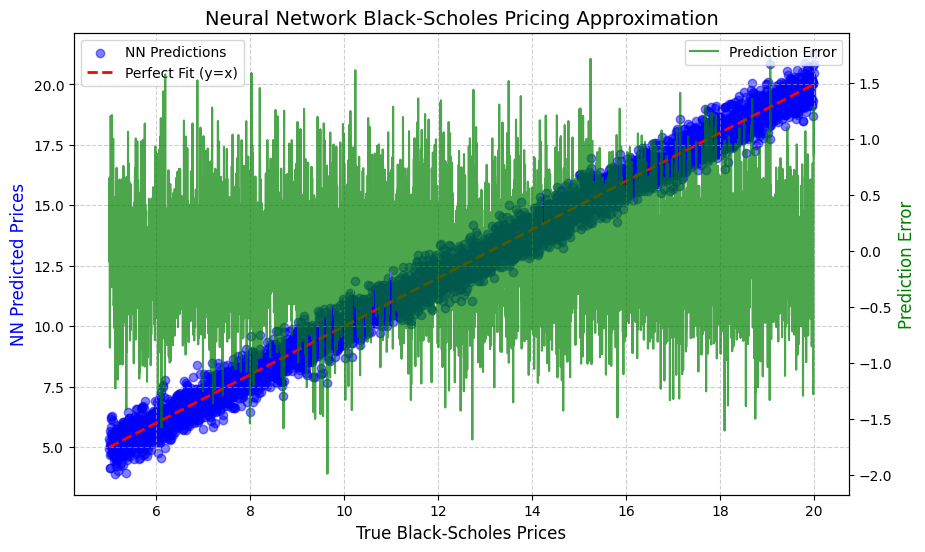

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Generate example data (for demonstration)
n_samples = 5000
true_prices = np.linspace(5, 20, n_samples)  # Simulated true Black-Scholes prices
predicted_prices = true_prices + np.random.normal(0, 0.5, n_samples)  # Simulated NN predictions with small error
errors = predicted_prices - true_prices  # Compute errors

# Create a professional plot with twin y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot of true vs predicted prices
ax1.scatter(true_prices, predicted_prices, alpha=0.5, color='blue', label="NN Predictions")
ax1.plot(true_prices, true_prices, color='red', linestyle="dashed", linewidth=2, label="Perfect Fit (y=x)")

# Labels, title, and grid
ax1.set_xlabel("True Black-Scholes Prices", fontsize=12)
ax1.set_ylabel("NN Predicted Prices", fontsize=12, color="blue")
ax1.set_title("Neural Network Black-Scholes Pricing Approximation", fontsize=14)
ax1.grid(True, linestyle="--", alpha=0.6)

# Twin axis for error visualization
ax2 = ax1.twinx()
ax2.plot(true_prices, errors, color='green', linestyle='solid', linewidth=1.5, alpha=0.7, label="Prediction Error")
ax2.set_ylabel("Prediction Error", fontsize=12, color="green")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

## 5. Extending to Stochastic Models (Heston)

While Black-Scholes has a closed-form solution, many models (e.g., Heston) do not. We simulate Heston paths and show how AI can approximate pricing functionals.

### Heston Model Dynamics:

$$ dS_t = \mu S_t dt + \sqrt{V_t} S_t dW_t^S $$

$$ dV_t = \kappa (\theta - V_t) dt + \xi \sqrt{V_t} dW_t^V $$

where$ W_t^S$ and$ W_t^V$ are correlated Brownian motions.

We approximate the price functional using a neural network.


## 6. Simulating the Heston Model

Since Black-Scholes assumes constant volatility, it may not capture market behaviors like volatility clustering. The **Heston Model** introduces stochastic volatility:

### **Heston Model SDEs:**
$$ dS_t = \mu S_t dt + \sqrt{V_t} S_t dW_t^S $$

$$ dV_t = \kappa (\theta - V_t) dt + \xi \sqrt{V_t} dW_t^V $$

where:
-$ S_t$ is the asset price.

-$ V_t$ is the stochastic variance.

-$ \kappa$ is the rate of mean reversion.

-$ \theta$ is the long-run variance.

-$ \xi$ is the volatility of variance.

-$ W_t^S$ and$ W_t^V$ are correlated Wiener processes with correlation$ \rho$.

We use the **Euler-Maruyama scheme** for discretization.


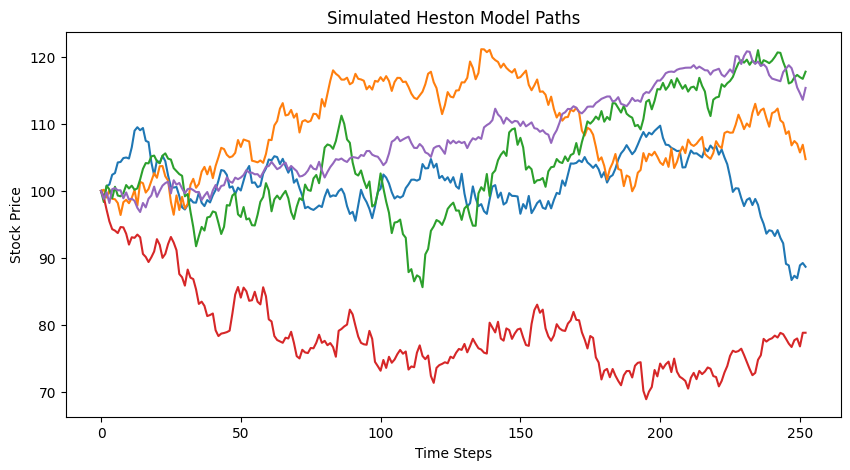

In [25]:
def simulate_heston(S0, V0, T, r, kappa, theta, xi, rho, steps, n_paths):
    dt = T / steps
    S = np.zeros((steps + 1, n_paths))
    V = np.zeros((steps + 1, n_paths))
    S[0], V[0] = S0, V0

    for t in range(1, steps + 1):
        Z_S = np.random.standard_normal(n_paths)
        Z_V = rho * Z_S + np.sqrt(1 - rho**2) * np.random.standard_normal(n_paths)
        
        V_t = np.maximum(V[t-1] + kappa * (theta - V[t-1]) * dt + xi * np.sqrt(V[t-1] * dt) * Z_V, 0)
        S_t = S[t-1] * np.exp((r - 0.5 * V[t-1]) * dt + np.sqrt(V[t-1] * dt) * Z_S)
        
        S[t] = S_t
        V[t] = V_t
    
    return S, V

# Parameters
S0, V0, T, r = 100, 0.04, 1, 0.05
kappa, theta, xi, rho = 2.0, 0.04, 0.3, -0.7
steps, n_paths = 252, 10000

# Simulate Heston paths
S_paths, V_paths = simulate_heston(S0, V0, T, r, kappa, theta, xi, rho, steps, n_paths)

# Plot example paths
plt.figure(figsize=(10, 5))
plt.plot(S_paths[:, :5])
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("Simulated Heston Model Paths")
plt.show()

## 7. Learning Option Prices from Heston Simulations

Since the Heston model does not have a simple closed-form solution (except via FFT for European options), we approximate the **pricing functional** using neural networks.

We generate a dataset where:
- Inputs:$ (S_0, V_0, T, r, \kappa, \theta, \xi, \rho)$
- Target: The Monte Carlo estimated price (average payoff of simulated paths).


In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Heston Model Simulation Function
def simulate_heston(S0, V0, T, r, kappa, theta, xi, rho, steps=100, n_paths=1000):
    dt = T / steps
    S = np.zeros((steps + 1, n_paths))
    V = np.zeros((steps + 1, n_paths))
    S[0], V[0] = S0, V0

    for t in range(1, steps + 1):
        Z_S = np.random.standard_normal(n_paths)
        Z_V = rho * Z_S + np.sqrt(1 - rho**2) * np.random.standard_normal(n_paths)
        
        V_t = np.maximum(V[t-1] + kappa * (theta - V[t-1]) * dt + xi * np.sqrt(V[t-1] * dt) * Z_V, 0)
        S_t = S[t-1] * np.exp((r - 0.5 * V[t-1]) * dt + np.sqrt(V[t-1] * dt) * Z_S)
        
        S[t] = S_t
        V[t] = V_t

    return S, V

# Generate synthetic dataset
n_samples = 1000  # Reduce sample size for efficiency
S0_range = np.linspace(80, 120, n_samples)
V0_range = np.linspace(0.01, 0.1, n_samples)
T_range = np.linspace(0.1, 2, n_samples)
kappa_range = np.linspace(1, 5, n_samples)
theta_range = np.linspace(0.02, 0.1, n_samples)
xi_range = np.linspace(0.1, 0.5, n_samples)
rho_range = np.linspace(-0.9, 0.9, n_samples)
r_range = np.full(n_samples, 0.05)

inputs = np.vstack([S0_range, V0_range, T_range, kappa_range, theta_range, xi_range, rho_range, r_range]).T
outputs = []

# Simulate option pricing using the Heston model
for i in range(n_samples):
    S_paths, _ = simulate_heston(S0_range[i], V0_range[i], T_range[i], r_range[i], 
                                 kappa_range[i], theta_range[i], xi_range[i], rho_range[i], 
                                 steps=50, n_paths=500)  # Reduced paths for efficiency
    
    payoffs = np.maximum(S_paths[-1] - 100, 0)  # European call option payoff
    option_price = np.exp(-r_range[i] * T_range[i]) * np.mean(payoffs)  # Discounted expectation
    outputs.append(option_price)

outputs = np.array(outputs)

# Convert to tensors
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
outputs_tensor = torch.tensor(outputs.reshape(-1, 1), dtype=torch.float32)

# Define a neural network model
class HestonNN(nn.Module):
    def __init__(self):
        super(HestonNN, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Initialize and train the model
model = HestonNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = model(inputs_tensor)
    loss = criterion(preds, outputs_tensor)
    loss.backward()
    optimizer.step()

# Compare true and predicted prices
preds_np = model(inputs_tensor).detach().numpy()

# Display a few input-output pairs for validation
example_idx = np.random.randint(0, n_samples, 5)
print("Example Input Vectors (S0, V0, T, kappa, theta, xi, rho, r) and Corresponding Prices")
for i in example_idx:
    print(f"Input: {inputs[i]}, True Price: {outputs[i]:.4f}, NN Prediction: {preds_np[i][0]:.4f}")


Example Input Vectors (S0, V0, T, kappa, theta, xi, rho, r) and Corresponding Prices
Input: [1.05545546e+02 6.74774775e-02 1.31341341e+00 3.55455455e+00
 7.10910911e-02 3.55455455e-01 2.49549550e-01 5.00000000e-02], True Price: 18.1790, NN Prediction: 18.9986
Input: [1.10830831e+02 7.93693694e-02 1.56446446e+00 4.08308308e+00
 8.16616617e-02 4.08308308e-01 4.87387387e-01 5.00000000e-02], True Price: 23.2420, NN Prediction: 25.0399
Input: [ 9.56156156e+01  4.51351351e-02  8.41741742e-01  2.56156156e+00
  5.12312312e-02  2.56156156e-01 -1.97297297e-01  5.00000000e-02], True Price: 7.3583, NN Prediction: 7.6485
Input: [1.13353353e+02 8.50450450e-02 1.68428428e+00 4.33533534e+00
 8.67067067e-02 4.33533534e-01 6.00900901e-01 5.00000000e-02], True Price: 28.9993, NN Prediction: 27.9232
Input: [1.05385385e+02 6.71171171e-02 1.30580581e+00 3.53853854e+00
 7.07707708e-02 3.53853854e-01 2.42342342e-01 5.00000000e-02], True Price: 19.5040, NN Prediction: 18.8156


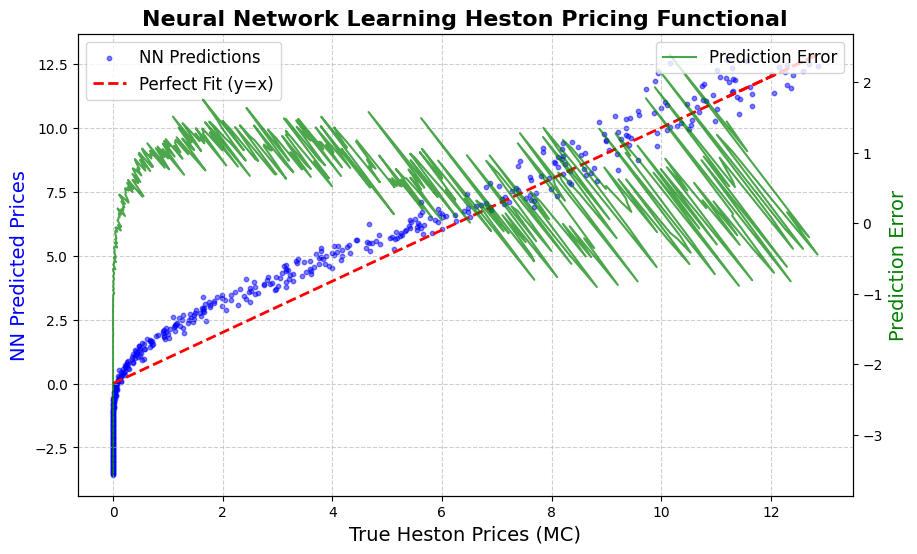

In [37]:
import matplotlib.pyplot as plt

# Reduce sample size for efficient plotting
n_samples_plot = 500  # Further reduce for visualization
true_prices = outputs[:n_samples_plot]  # True Heston Prices from MC Simulation
predicted_prices = preds_np[:n_samples_plot].flatten()  # Neural Network Predictions
errors = predicted_prices - true_prices  # Compute errors

# Create a professional plot with twin y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot of true vs predicted prices
ax1.scatter(true_prices, predicted_prices, alpha=0.5, color='blue', label="NN Predictions", s=10)
ax1.plot(true_prices, true_prices, color='red', linestyle="dashed", linewidth=2, label="Perfect Fit (y=x)")

# Labels, title, and grid
ax1.set_xlabel("True Heston Prices (MC)", fontsize=14)
ax1.set_ylabel("NN Predicted Prices", fontsize=14, color="blue")
ax1.set_title("Neural Network Learning Heston Pricing Functional", fontsize=16, fontweight='bold')
ax1.grid(True, linestyle="--", alpha=0.6)

# Twin axis for error visualization
ax2 = ax1.twinx()
ax2.plot(true_prices, errors, color='green', linestyle='solid', linewidth=1.5, alpha=0.7, label="Prediction Error")
ax2.set_ylabel("Prediction Error", fontsize=14, color="green")

# Legends
ax1.legend(loc="upper left", fontsize=12)
ax2.legend(loc="upper right", fontsize=12)

# Display the plot
plt.show()

## 8. Discussion on Current Literature and Future Research

### **Key Takeaways**
1. **Black-Scholes can be learned by a neural network**: We demonstrated that a feedforward network can approximate Black-Scholes prices.
2. **Neural networks as function approximators**: Universal Approximation Theorem suggests they can learn any continuous function, making them ideal for pricing models.
3. **Extension to stochastic models**: Heston simulations were used to train a network to approximate pricing functionals, similar to **Horvath et al.** and **Hull et al.**.

### **Current Research Trends**
- **Neural-SDEs for option pricing**: Instead of approximating pricing functionals, researchers explore learning the SDE dynamics directly.
- **Deep Hedging (Buehler et al.)**: Using reinforcement learning to hedge options dynamically without assuming a model.
- **Neural Network Calibration**: Fast and accurate calibration of complex models, reducing the need for expensive numerical methods.

### **References**
1. Horvath, Muguruza, Tomas (2019). Deep Learning Volatility.
2. Hull, Basu (2022). Neural Network Option Pricing.
3. Buehler et al. (2019). Deep Hedging.

This notebook provides a practical introduction to these ideas and serves as a bridge between traditional finance models and modern AI techniques.
